## Imports and Setup
This notebook implements an XGBoost model for electricity price prediction using TTF gas prices and temporal features.

In [ ]:
%pip install xgboost==2.1.4 pandas scikit-learn matplotlib
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Data Loading and Preprocessing
Load TTF gas prices and electricity prices, align their timestamps and clean missing values.

In [ ]:
# Load and prepare data
ttf_hourly = pd.read_csv('../Data/TTF_hourly_prediction.csv', parse_dates=['Date'])
elec_hourly = pd.read_csv('../Data/Netherlands.csv', parse_dates=['Datetime (UTC)'])

# Set index for both
ttf_hourly = ttf_hourly.set_index('Date')
elec_hourly = elec_hourly.set_index('Datetime (UTC)')

# Create full hourly range
full_range = pd.date_range(
    start=max(ttf_hourly.index.min(), elec_hourly.index.min()),
    end=min(ttf_hourly.index.max(), elec_hourly.index.max()),
    freq='H'
)

# Reindex and clean data
ttf_hourly = ttf_hourly.reindex(full_range)
elec_hourly = elec_hourly.reindex(full_range)

y = elec_hourly['Price (EUR/MWhe)']
exog = ttf_hourly['Price']

mask = (~y.isnull()) & (~exog.isnull())
y_clean = y[mask]
exog_clean = exog[mask]

print("Data shapes after cleaning:")
print(f"y_clean: {y_clean.shape}")
print(f"exog_clean: {exog_clean.shape}")

## Feature Engineering
Add time-based features to capture temporal patterns in electricity prices.

In [4]:
def add_time_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    return df

# Split and prepare features
test_start_date = pd.Timestamp('2024-01-01 00:00:00')
y_train = y_clean.loc[y_clean.index < test_start_date]
y_test = y_clean.loc[y_clean.index >= test_start_date]

# Add features and scale
X_train = add_time_features(pd.DataFrame({'ttf_price': exog_clean.loc[exog_clean.index < test_start_date]}))
X_test = add_time_features(pd.DataFrame({'ttf_price': exog_clean.loc[exog_clean.index >= test_start_date]}))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)

Training set shape: (43800, 6)
Test set shape: (12685, 6)


## Model Training
Train XGBoost model with early stopping to prevent overfitting.

In [5]:
model_xgb = xgb.XGBRegressor(
    n_estimators=1000,  # Increased as we're using early stopping
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=10  # Added here for v2.1.4
)

# Fit model with eval_set
model_xgb.fit(
    X_train_scaled, 
    y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## Model Evaluation
Calculate metrics and visualize predictions vs actual values.

Test MAE: 26.32 EUR/MWhe
Test RMSE: 40.61 EUR/MWhe


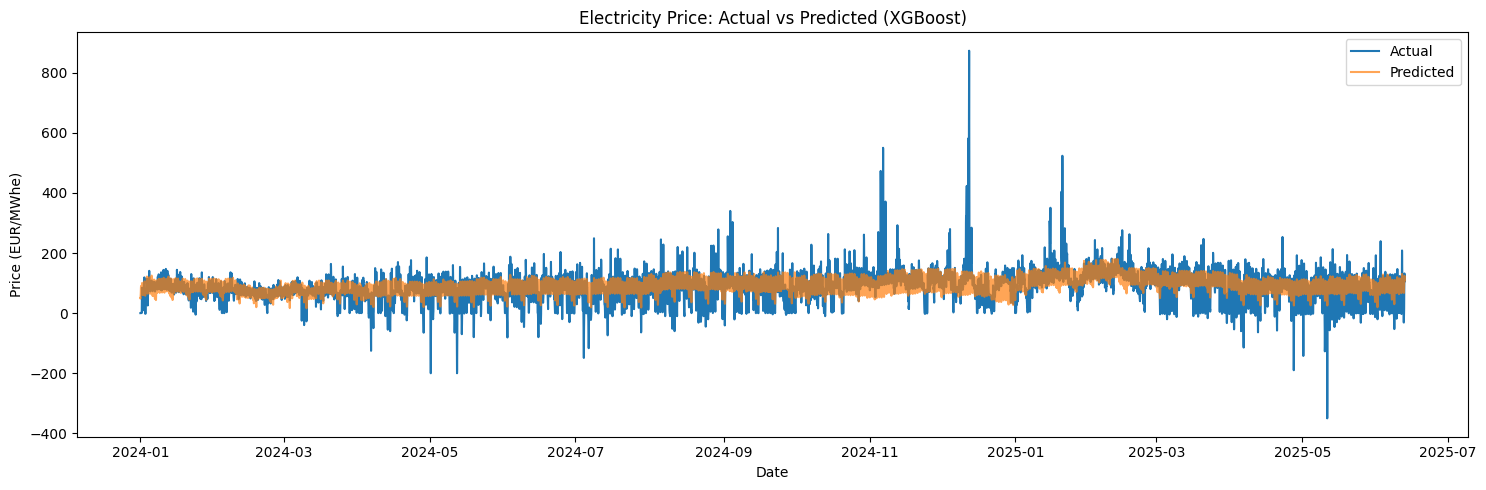

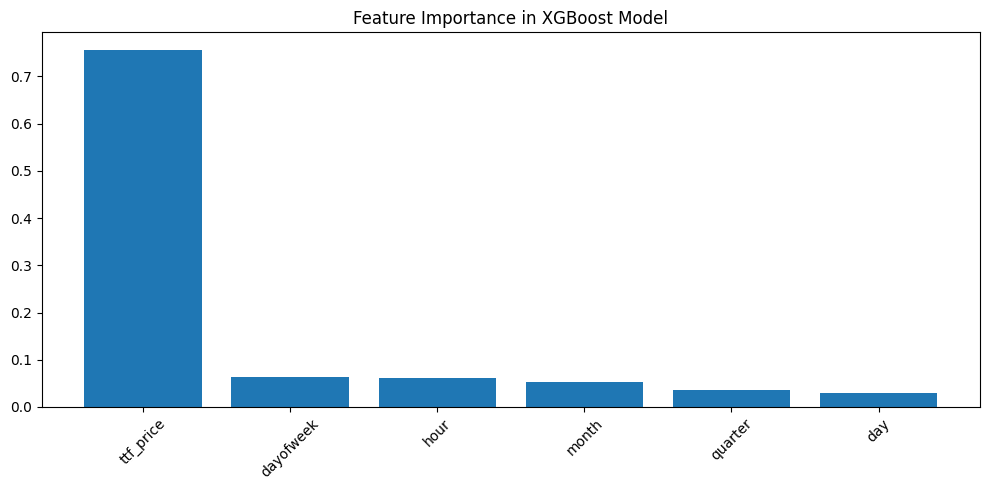

In [6]:
y_pred = pd.Series(
    model_xgb.predict(X_test_scaled),
    index=y_test.index
)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test MAE: {mae:.2f} EUR/MWhe")
print(f"Test RMSE: {rmse:.2f} EUR/MWhe")

# Plot results
plt.figure(figsize=(15,5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.7)
plt.legend()
plt.title('Electricity Price: Actual vs Predicted (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Price (EUR/MWhe)')
plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model_xgb.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10,5))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance in XGBoost Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/py/tttdp81n4rj_y9mxm1f1br6r0000gn/T/ipykernel_45547/254271722.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(
/var/folders/py/tttdp81n4rj_y9mxm1f1br6r0000gn/T/ipykernel_45547/254271722.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  prophet_ttf_forecast = pd.read_csv('../Data/TTF_hourly_prediction.csv', parse_dates=['Date'])


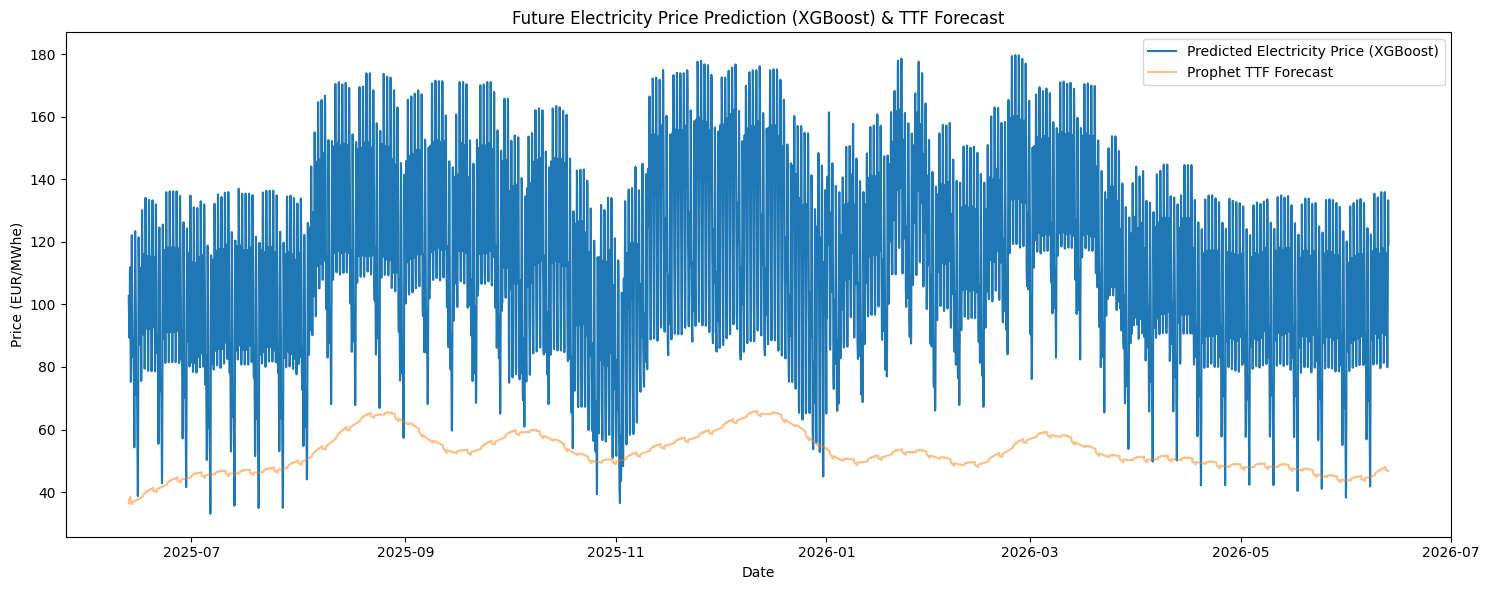

In [11]:
# 1. Create future DataFrame (hourly)
future_dates = pd.date_range(
    start='2025-06-12 21:00:00',
    end='2026-06-12 20:00:00',
    freq='H'
)
future_df = pd.DataFrame(index=future_dates)

# 2. Merge with Prophet forecasted TTF values
# prophet_ttf_forecast must have columns: 'Date' (datetime) and 'yhat'
# Example: Load Prophet forecast from CSV (update the path as needed)
prophet_ttf_forecast = pd.read_csv('../Data/TTF_hourly_prediction.csv', parse_dates=['Date'])
prophet_ttf_forecast = prophet_ttf_forecast.set_index('Date')
future_df = future_df.join(prophet_ttf_forecast['Price'].rename('ttf_price'))

# 3. Add time-based features
future_df = add_time_features(future_df)

# 4. Build and scale feature set
X_future = future_df
X_future_scaled = scaler.transform(X_future)

# 5. Predict using XGBoost
future_predictions = pd.Series(
    model_xgb.predict(X_future_scaled),
    index=future_df.index,
    name='Predicted Price'
)

# 6. Dashboard (plot)
plt.figure(figsize=(15,6))
plt.plot(future_predictions.index, future_predictions, label='Predicted Electricity Price (XGBoost)')
plt.plot(future_df.index, future_df['ttf_price'], label='Prophet TTF Forecast', alpha=0.5)
plt.title('Future Electricity Price Prediction (XGBoost) & TTF Forecast')
plt.xlabel('Date')
plt.ylabel('Price (EUR/MWhe)')
plt.legend()
plt.tight_layout()
plt.show()

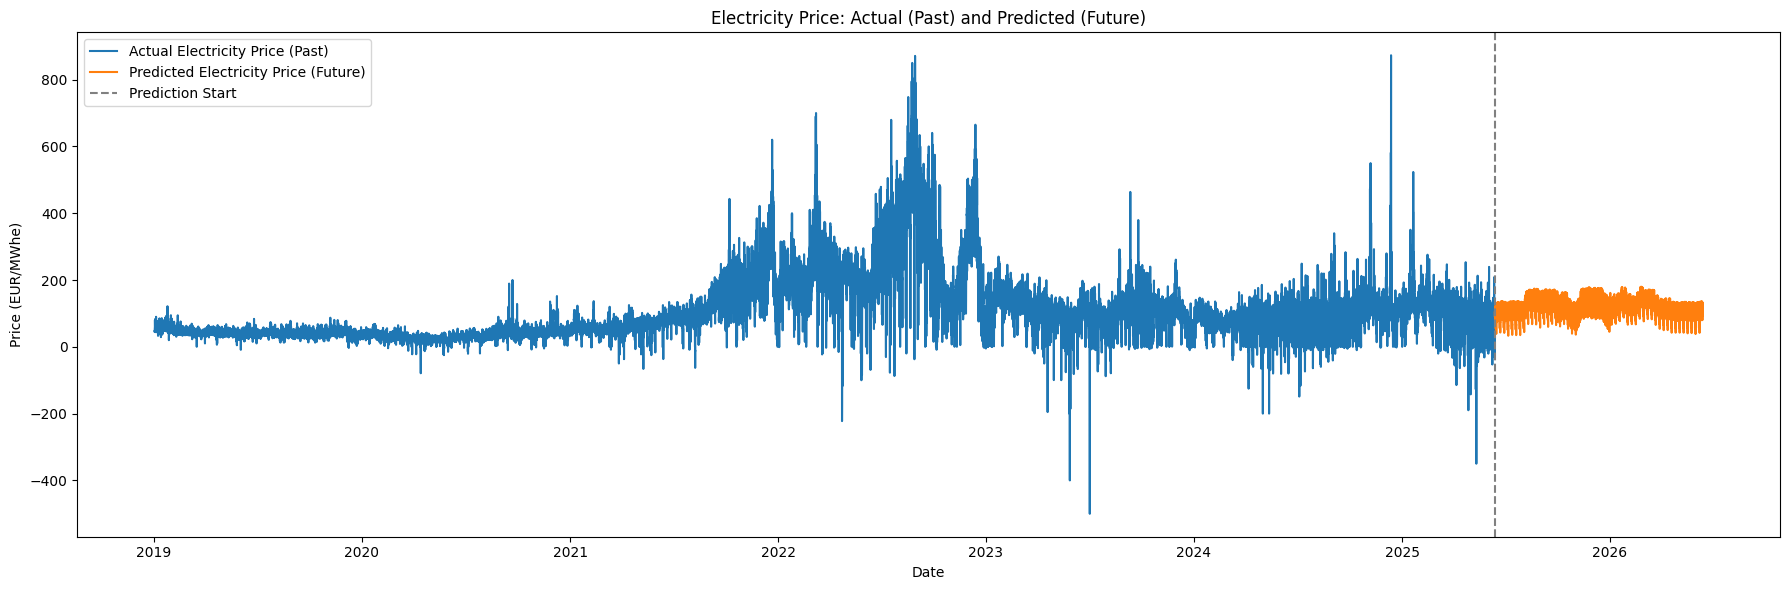

In [12]:
plt.figure(figsize=(18,6))
# Plot historical actuals
plt.plot(y_clean.index, y_clean, label='Actual Electricity Price (Past)', color='tab:blue')
# Plot future predictions
plt.plot(future_predictions.index, future_predictions, label='Predicted Electricity Price (Future)', color='tab:orange')
plt.axvline(x=future_predictions.index[0], color='gray', linestyle='--', label='Prediction Start')
plt.xlabel('Date')
plt.ylabel('Price (EUR/MWhe)')
plt.title('Electricity Price: Actual (Past) and Predicted (Future)')
plt.legend()
plt.tight_layout()
plt.show()